# Mini project - Emotion and gender speech audio classification using CNN and LSTM

In [1]:
# All imports
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display

import librosa
import librosa.display
import sklearn as sk

# Set the seed value for experiment reproducibility.
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)
sk.random.seed(seed)

### Helper functions

In [249]:
def genderNumToString(num):
    return 'M' if num % 2 == 1 else 'F'

def emotionNumToString(num):
    emotionString = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    return emotionString[num]

def plotAudio(data, genderLabel, emotionLabel, rows = 1, cols = 1,figsize=(16, 9), ylim=1):

    n = rows * cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i in range(n):
        if i>=n:
            break
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.plot(data[i])
        label = genderNumToString(genderLabel[i]) + ' | ' + emotionNumToString(emotionLabel[i]) 
        ax.set_title(label)
        ax.set_ylim([-ylim, ylim])

    plt.show()

## Load the data

In [251]:
datasetPath = 'audio_speech_actors_01-24'
sampleRate = 16000
sampleOffset = 1
sampleDuration = 2

data = []
genderLabel = []
emotionLabel = []

for actorPath in os.listdir(datasetPath):
    for audioFile in os.listdir(datasetPath + '/' + actorPath):
        y, sr = librosa.load(datasetPath + '/' + actorPath + '/' + audioFile, sr=sampleRate, offset=sampleOffset, duration=sampleDuration)
        y = np.pad(y, (0, sampleRate*sampleDuration - len(y)))
        data.append(y)
        
        fileName = audioFile.split('.')[0].split('-')
        genderLabel.append(int(fileName[-1]))
        emotionLabel.append(int(fileName[2])-1)


## Before preprocessing

### Shuffle
Shuffle/Permute the data and the labels the same way

In [252]:
shuffledData, shuffledGenderLabel, shuffledEmotionLabel = sk.utils.shuffle(data, genderLabel, emotionLabel)

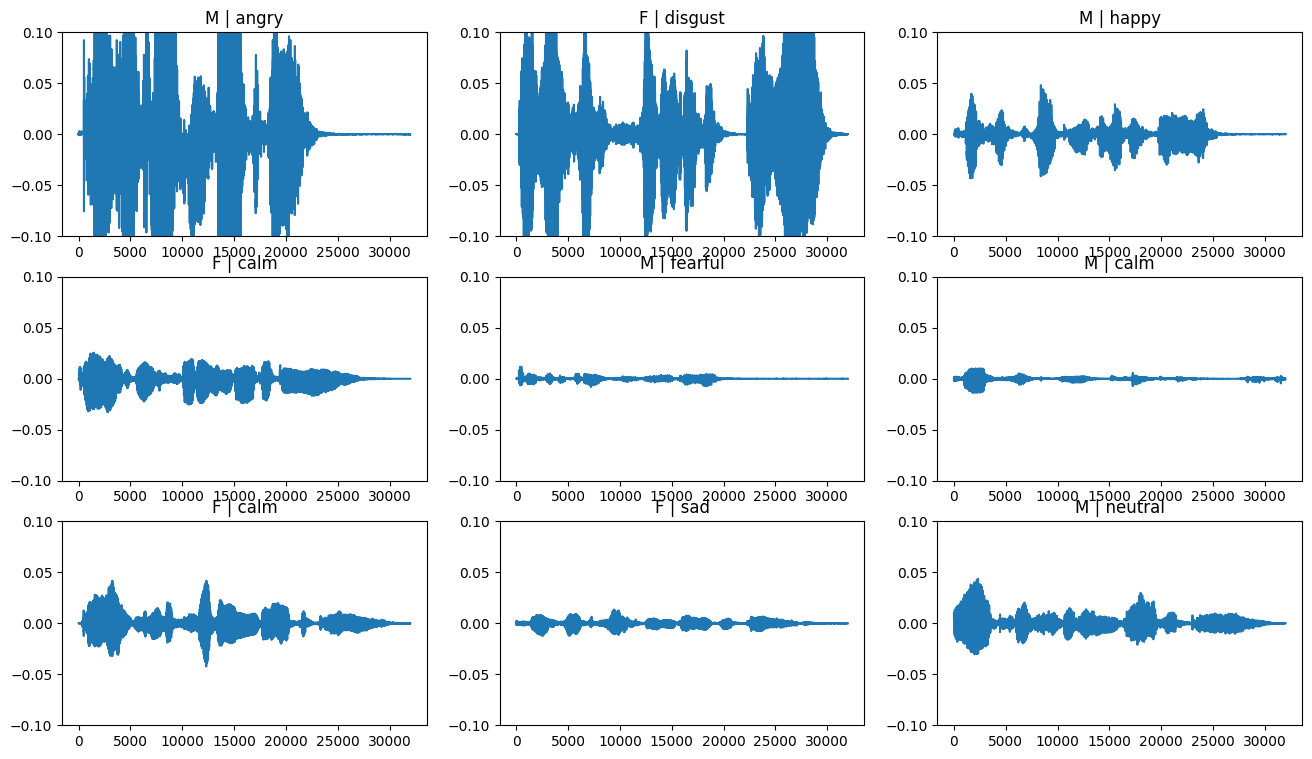

In [253]:
plotAudio(shuffledData, shuffledGenderLabel, shuffledEmotionLabel, ylim=.1, rows=3, cols=3)

## Preprocessing

### Sample less

In [254]:
# newAudio = []
# sampleLessData = []

# for audio in shuffledData:
#     for point in range(0, len(audio), 3):
#         newAudio.append(audio[point])
#     sampleLessData.append(newAudio)

# print(len(sampleLessData), sampleLessData)

In [255]:

# sampleLessData = np.array(sampleLessData, dtype=object)

### Pre-emphasis
To compensate the high-frequency secion which is naturaly suppressed

In [256]:
preEmphasisData = []

for audio in shuffledData:
    preEmphasisData.append(librosa.effects.preemphasis(audio))


### Normilization
Put the data in the range of -1 to 1


In [257]:
def normalize(x, axis=0):
    # return sk.preprocessing.normalize(x)
    return sk.preprocessing.minmax_scale(x, feature_range=(-1,1), axis=axis)

normilizedData = []
for audio in preEmphasisData:
    normilizedData.append(normalize(audio))

normilizedData = np.array(normilizedData, dtype=object)
    

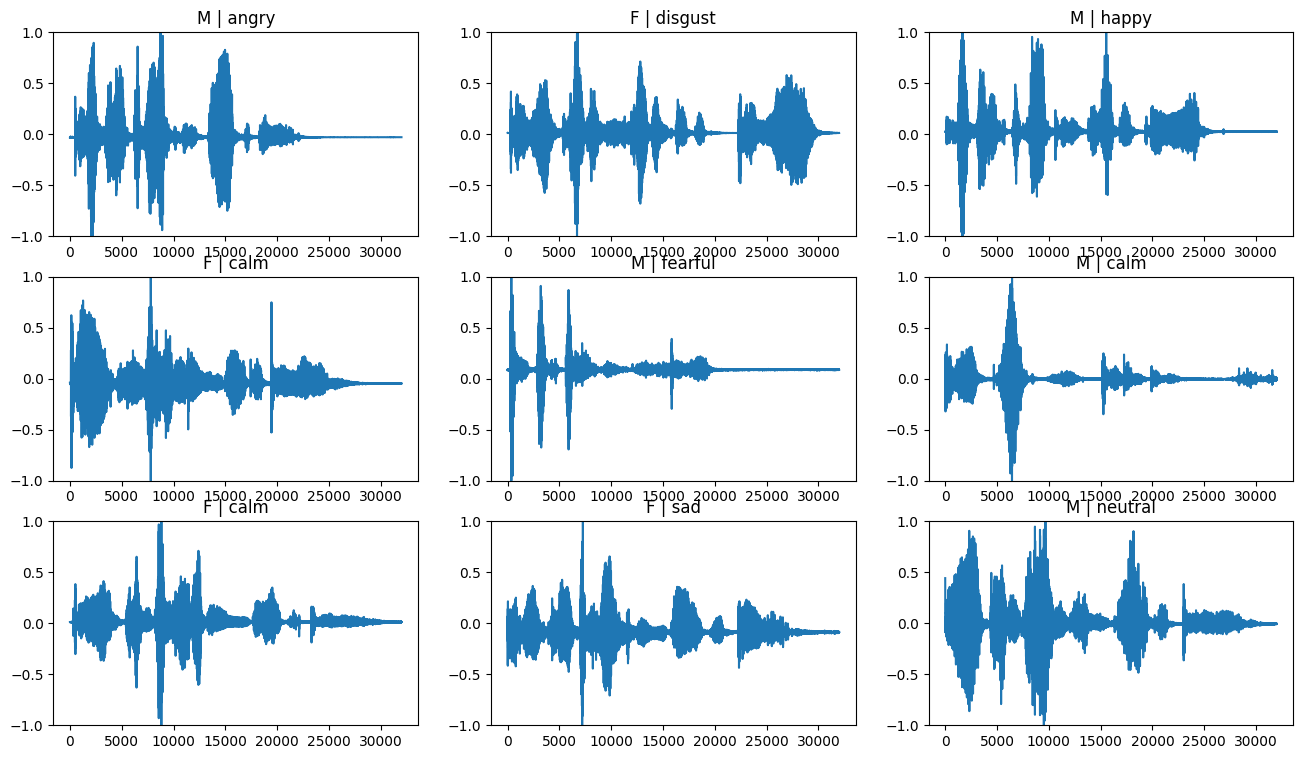

In [258]:
plotAudio(normilizedData, shuffledGenderLabel, shuffledEmotionLabel, ylim=1, rows=3, cols=3)

# Fearure Extraction

Extact features of all audio files to get better data for defining differences between the data and to make the neural nets better and faster

* **Zero crossing rate:** Calculate the amout of times the singal crosses 0 on the x axis.
* **Mel-frequency cepstral coefficients:** This is coefficients that collectively make up an MFC, which are derived from a type of cepstrum of the audio.
* **Chroma feature analysis and synthesis:** Compute a chromagram from a waveform or power spectrogram.
* **Spectral roll-off:** Compute roll-off frequency. 

In [259]:
featureData = []


for audio in normilizedData:
    audio = audio.astype(float)

    zcr = librosa.feature.zero_crossing_rate(y = audio)
    zcr = zcr.reshape(zcr.shape[0]*zcr.shape[1])

    mfcc = librosa.feature.mfcc(y = audio, sr = sampleRate)
    mfcc = mfcc.reshape(mfcc.shape[0]*mfcc.shape[1])

    stft = librosa.feature.chroma_stft(y = audio, sr = sampleRate)
    stft = stft.reshape(stft.shape[0]*stft.shape[1])

    rolloff = librosa.feature.spectral_rolloff(y = audio, sr = sampleRate)
    rolloff = rolloff.reshape(rolloff.shape[0]*rolloff.shape[1])

    featureData.append(np.concatenate((zcr, mfcc, stft, rolloff)))

featureData = np.array(featureData, dtype=object)


c:\Users\isakl\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


# Pre-model creation

In [280]:
featureData2 = np.expand_dims(np.expand_dims(featureData, axis=2), axis=2)
featureData2 = np.asarray(featureData).astype('float32')

In [281]:
featureData2.shape, featureData.shape

((1440, 2142), (1440, 2142))

In [282]:
length = len(featureData)
splitRatio = 0.8
split = int(length*splitRatio)

# Split data and labels into train and test sets
trainData = featureData2[:split]
trainGenderLabel = shuffledGenderLabel[:split]
trainEmotionLabel = shuffledEmotionLabel[:split]

testData = featureData2[split:]
testGenderLabel = shuffledGenderLabel[split:]
testEmotionLabel = shuffledEmotionLabel[split:]

In [283]:
trainData.shape, trainData[0].shape, trainData[0]

((1152, 2142),
 (2142,),
 array([8.9355469e-02, 1.9384766e-01, 2.6220703e-01, ..., 7.8125000e+00,
        4.6875000e+01, 1.7890625e+03], dtype=float32))

# Model creation and training

In [284]:
emotionModel = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu', input_shape=(trainData[0].shape)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(8, activation='softmax')
])

emotionModel.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 128)               274304    
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_82 (Dense)            (None, 32)                4128      
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 dense_83 (Dense)            (None, 32)                1056      
                                                                 
 dense_84 (Dense)            (None, 8)                 264       
                                                                 
Total params: 279,752
Trainable params: 279,752
Non-t

In [285]:
np.array(trainEmotionLabel)

array([4, 6, 2, ..., 7, 2, 2])

In [290]:
emotionModel.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,metrics=['accuracy'])

epochs = 100
history = emotionModel.fit(trainData, np.array(trainEmotionLabel), batch_size=128, epochs=epochs, validation_data=(testData, np.array(testEmotionLabel)))

Epoch 1/100
9/9 [==============================] - 2s 74ms/step - loss: 2.0823 - accuracy: 0.1328 - val_loss: 2.0803 - val_accuracy: 0.1285
Epoch 2/100
9/9 [==============================] - 0s 15ms/step - loss: 2.0693 - accuracy: 0.1484 - val_loss: 2.0650 - val_accuracy: 0.1250
Epoch 3/100
9/9 [==============================] - 0s 15ms/step - loss: 2.0744 - accuracy: 0.1302 - val_loss: 2.0619 - val_accuracy: 0.1354
Epoch 4/100
9/9 [==============================] - 0s 16ms/step - loss: 2.0799 - accuracy: 0.1302 - val_loss: 2.0669 - val_accuracy: 0.1076
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 2.0791 - accuracy: 0.1328 - val_loss: 2.0832 - val_accuracy: 0.1181
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 2.0741 - accuracy: 0.1424 - val_loss: 2.0839 - val_accuracy: 0.1181
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - loss: 2.0782 - accuracy: 0.1432 - val_loss: 2.0699 - val_accuracy: 0.1250
Epoch 8/100
9/9 [===

9/9 - 0s - loss: 2.0633 - accuracy: 0.1285 - 54ms/epoch - 6ms/step


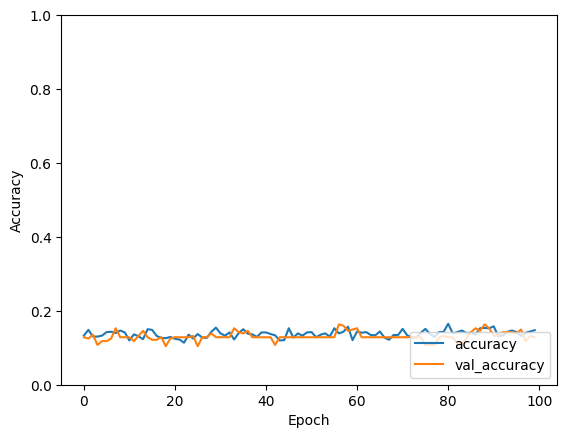

In [291]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

testLoss, testAcc = emotionModel.evaluate(testData, np.array(testEmotionLabel), verbose=2)